
# Prototype 1 — Category Sentiment by Month (Guadalupe Peak Trail)

This notebook loads cleaned AllTrails reviews, extracts category-specific snippets, scores sentiment (VADER if available, else a simple fallback), aggregates by **month**, and visualizes trends for:

- **Views**
- **Difficulty**
- **Crowding**
- **Overall Experience**

It also saves a monthly summary CSV for quick reference.



## Repository Assumptions

```
Data/Cleaned_Trail_Reviews.csv   # cleaned dataset (Date, Content, Features, Rating, ...)
Prototype/                        # your notebooks live here (this file can be here)
```


In [ ]:
# OPTIONAL: Install VADER if you want more nuanced sentiment locally
# !pip install vaderSentiment
# If you plan to use TextBlob instead:
# !pip install textblob


In [2]:
import os
import re
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


DATA_PATH = os.path.join('Data', 'Cleaned_Trail_Reviews.csv')
df = pd.read_csv(DATA_PATH)

df = df.dropna(subset=['Date', 'Content', 'Rating']).copy()
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date']).copy()
df['Content_lc'] = df['Content'].astype(str).str.lower()

print(df.head(3))

   Unnamed: 0       Date                                            Content  \
0           0 2025-07-31  Trail is easy to follow and in great shape. It...   
1           1 2025-07-30  Hot, but spectacular views, really puts into p...   
2           2 2025-07-25  Tough hike but amazing views. The climb is fai...   

                                            Features  Rating  \
0  Easy to park, Not crowded, Great conditions, G...     5.0   
1  Easy to park, Not crowded, Great conditions, G...     5.0   
2  Easy to park, Not crowded, Great conditions, G...     5.0   

                                          Content_lc  
0  trail is easy to follow and in great shape. it...  
1  hot, but spectacular views, really puts into p...  
2  tough hike but amazing views. the climb is fai...  


## Category Lexicons

In [3]:
categories = {
    "Views": [
        r"view(s)?", r"scenery", r"scenic", r"panorama(tic)?", r"picturesque",
        r"gorgeous", r"stunning", r"spectacular", r"breathtaking", r"majestic",
        r"vista(s)?", r"sweeping", r"phot(o|ograph)(s)?", r"shot(s)?",
        r"sunrise", r"sunset", r"milky\\s*way", r"stars?", r"night\\s*sky",
        r"lookout", r"overlook", r"horizon", r"landscape", r"peak", r"summit"
    ],
    "Difficulty": [
        r"hard", r"challenging", r"strenuous", r"steep", r"tough", r"brutal",
        r"intense", r"grueling", r"relentless", r"slog", r"switchback(s)?",
        r"elevation\\s*gain", r"cardio", r"winded", r"burn", r"killer"
    ],
    "Crowding": [
        r"crowd(ed|ing)?", r"busy", r"packed", r"congested", r"line(s)?",
        r"traffic", r"parking\\s*(lot)?\\s*(full|packed|closed)",
        r"not\\s*crowded", r"quiet", r"peaceful", r"solitude",
        r"lots\\s*of\\s*people", r"many\\s*people", r"noisy", r"tourist(y)?"
    ],
    "Overall": [
        r"overrated", r"underwhelming", r"meh", r"mediocre", r"disappoint(ing|ed)",
        r"terrible", r"awful", r"worst", r"bad", r"waste",
        r"incredible", r"amazing", r"awesome", r"fantastic", r"phenomenal",
        r"unreal", r"favorite", r"best", r"great", r"excellent", r"perfect",
        r"memorable", r"must[-\\s]?do", r"worth(\\s*it)?", r"recommend(ed)?",
        r"would\\s*recommend", r"highly\\s*recommend", r"do\\s*again",
        r"never\\s*again"
    ]
}


cat_regex = {cat: [re.compile(pat) for pat in pats] for cat, pats in categories.items()}

## Sentiment Scoring (VADER if available, otherwise simple fallback)

In [4]:
def try_load_vader():
    try:
        from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
        return SentimentIntensityAnalyzer()
    except Exception:
        return None

vader = try_load_vader() # will work since vader is installed, so ignore below for this cell

POS_WORDS = set("""
beautiful scenic panoramic picturesque gorgeous stunning spectacular
breathtaking majestic sweeping incredible vista vistas incredible amazing awesome
fantastic phenomenal unreal favorite best great excellent perfect memorable
worth worthwhile worthit recommend recommended recommending recommends
highly_recommend mustdo must_do must-do must see must_see must-see
priceless rewarding epic killer impressive lovely delightful peaceful
""".split())

NEG_WORDS = set("""
overrated underwhelming meh mediocre disappointing disappointed terrible
awful worst bad waste never_again regret regretted brutal exhausting painful
dangerous slippery hazardous sketchy exposed shadeless unbearable miserable
crowded busy packed congested noisy line lines traffic full closed closure
""".split())


import re as _re

def simple_sentiment(text: str) -> float:
    if not text:
        return np.nan
    toks = _re.findall(r"[a-zA-Z']+", text.lower())
    if not toks:
        return np.nan
    pos = sum(1 for t in toks if t in POS_WORDS)
    neg = sum(1 for t in toks if t in NEG_WORDS)
    if pos == 0 and neg == 0:
        return 0.0
    return (pos - neg) / (pos + neg)

def score_text(text: str) -> float:
    if not isinstance(text, str) or not text.strip():
        return np.nan
    if vader is not None:
        try:
            return float(vader.polarity_scores(text)['compound'])
        except Exception:
            pass
    return simple_sentiment(text)

def apply_simple_negation_flip(text: str, base_score: float) -> float:
    if text and "not crowded" in text:
        return -base_score if base_score != 0 else 0.4  # tilt positive if neutral
    return base_score


In [5]:
test_text = "Tough hike but amazing views. The climb is fairly steep the entire trail and not for beginners."
print("Score with VADER or fallback:", score_text(test_text))
# Just a test

Score with VADER or fallback: 0.714


## Extract Category-Specific Snippets

In [6]:
def extract_category_text(full_text: str, regex_list) -> str:
    if not isinstance(full_text, str) or not full_text.strip():
        return ""
    sents = re.split(r'(?<=[\.!?])\s+', full_text.lower())
    keep = []
    for s in sents:
        if any(p.search(s) for p in regex_list):
            keep.append(s)
    return " ".join(keep)

for cat in categories.keys():
    df[f"{cat}_snippet"] = df['Content_lc'].apply(lambda t: extract_category_text(t, cat_regex[cat]))
    df[f"{cat}_sent"] = df[f"{cat}_snippet"].apply(score_text)

df['Overall_Review_sent'] = df['Content_lc'].apply(score_text)

cols_to_show = [c for c in ['Date','Rating','Views_sent','Difficulty_sent','Crowding_sent','Overall_sent','Overall_Review_sent'] if c in df.columns]
df.head(3)[cols_to_show] if cols_to_show else df.head(3)

,Date,Rating,Views_sent,Difficulty_sent,Crowding_sent,Overall_sent,Overall_Review_sent
0,2025-07-31,5.0,0.658,0.000,NaN,0.8217,0.9576
1,2025-07-30,5.0,0.000,NaN,NaN,NaN,0.0000
2,2025-07-25,5.0,0.714,0.714,NaN,0.7140,0.7140


In [7]:
#noticed a possible problem, as line 1 specifically mentions spectacular views and yet views sentiment is a 0. Exploring that.

print(extract_category_text("Hot, but spectacular views, really puts into perspective how flat the state is. Was not crowded at all.", cat_regex["Views"]))
print(score_text("spectacular views"))

hot, but spectacular views, really puts into perspective how flat the state is.
0.0


In [8]:
print("Using VADER?", vader is not None)           # True means VADER is active
print("Fallback score:", simple_sentiment("spectacular views"))
print("VADER score:", vader.polarity_scores("spectacular views")['compound'] if vader else None)
print("Final score_text:", score_text("spectacular views"))

#vader = None
print(score_text("spectacular views"))  # should be > 0 if 'spectacular' is in POS_WORDS


Using VADER? True
Fallback score: 1.0
VADER score: 0.0
Final score_text: 0.0
0.0


## This was really weird. Somehow it seems something built into VADER is overriding the fact that "Spectacular" should be seen as a positive word. Testing revealed that it's also the case for other words like "Incredible". A new approach was needed.

In [11]:
def score_text(text: str) -> float:
    if not isinstance(text, str) or not text.strip():
        return np.nan
    fb = simple_sentiment(text)
    if vader is not None:
        try:
            vd = float(vader.polarity_scores(text)['compound'])
            # prefer the domain fallback, lightly informed by VADER
            return 0.6 * fb + 0.4 * vd
        except Exception:
            pass
    return fb


In [12]:
print(score_text("spectacular views"))

0.6


In [20]:
for cat in categories.keys():
    df[f"{cat}_snippet"] = df['Content_lc'].apply(lambda t: extract_category_text(t, cat_regex[cat]))
    df[f"{cat}_sent"] = df[f"{cat}_snippet"].apply(score_text)

df['Overall_Review_sent'] = df['Content_lc'].apply(score_text)

df["Crowding_sent"] = df["Crowding_snippet"].apply(
    lambda s: apply_simple_negation_flip(s, score_text(s))
)


df.head(10)[cols_to_show] if cols_to_show else df.head(3)

,Date,Rating,Views_sent,Difficulty_sent,Crowding_sent,Overall_sent,Overall_Review_sent
0,2025-07-31,5.0,0.86320,0.00000,NaN,0.92868,0.98304
1,2025-07-30,5.0,0.60000,NaN,NaN,NaN,0.60000
2,2025-07-25,5.0,0.88560,0.88560,NaN,0.88560,0.88560
3,2025-07-23,5.0,0.98628,0.00000,NaN,0.88872,0.99336
4,2025-07-22,5.0,0.96448,NaN,NaN,0.95888,0.97680
5,2025-07-21,4.0,0.00000,NaN,0.14448,NaN,-0.43868
6,2025-07-20,5.0,0.81068,-0.04108,NaN,0.65120,0.81692
7,2025-07-19,5.0,0.82876,NaN,NaN,0.82876,0.82876
8,2025-07-16,5.0,0.96536,0.00000,NaN,0.78352,0.99284
9,2025-07-15,4.0,NaN,NaN,NaN,0.76804,0.93412


## Monthly Aggregation

In [27]:
df['Month'] = df['Date'].dt.to_period('M').dt.to_timestamp()

agg_cols = [f"{cat}_sent" for cat in categories.keys()] + ['Overall_Review_sent']
monthly = (
    df.groupby('Month')[agg_cols + ['Rating']]
      .agg(['mean', 'count'])
      .sort_index()
)
monthly.columns = ['_'.join([c for c in col if c]) for col in monthly.columns.to_flat_index()]
monthly = monthly.reset_index()
monthly

,Month,Views_sent_mean,Views_sent_count,Difficulty_sent_mean,Difficulty_sent_count,Crowding_sent_mean,Crowding_sent_count,Overall_sent_mean,Overall_sent_count,Overall_Review_sent_mean,Overall_Review_sent_count,Rating_mean,Rating_count
0,2024-08-01,0.483286,13,0.099053,12,0.727880,1,0.537012,10,0.499741,21,4.761905,21
1,2024-09-01,0.493044,21,0.211465,22,0.000000,5,0.709855,19,0.519275,30,4.900000,30
2,2024-10-01,0.632676,33,0.258981,27,-0.200760,6,0.814054,29,0.532229,60,4.688525,61
3,2024-11-01,0.461498,37,0.197288,35,-0.242792,5,0.742031,36,0.550192,58,4.775862,58
4,2024-12-01,0.572274,39,0.226079,28,0.010840,8,0.729176,36,0.539888,52,4.788462,52
5,2025-01-01,0.473835,26,0.181660,20,-0.056440,2,0.707123,26,0.607082,40,4.900000,40
6,2025-02-01,0.616890,24,0.345068,23,-0.029110,4,0.840603,26,0.625457,39,4.897436,39
7,2025-03-01,0.617925,45,0.171533,45,-0.080796,9,0.734303,51,0.569294,84,4.761905,84
8,2025-04-01,0.461102,54,0.164354,37,0.099687,6,0.731832,50,0.469071,86,4.697674,86
9,2025-05-01,0.443626,44,0.189845,33,-0.051596,10,0.734249,39,0.500373,67,4.820896,67


## Plots — Monthly Mean Sentiment and Rating

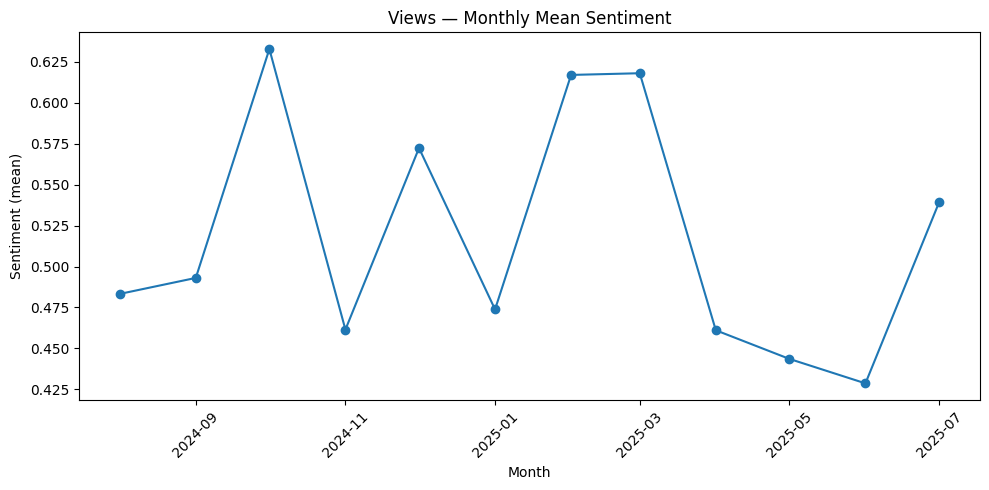

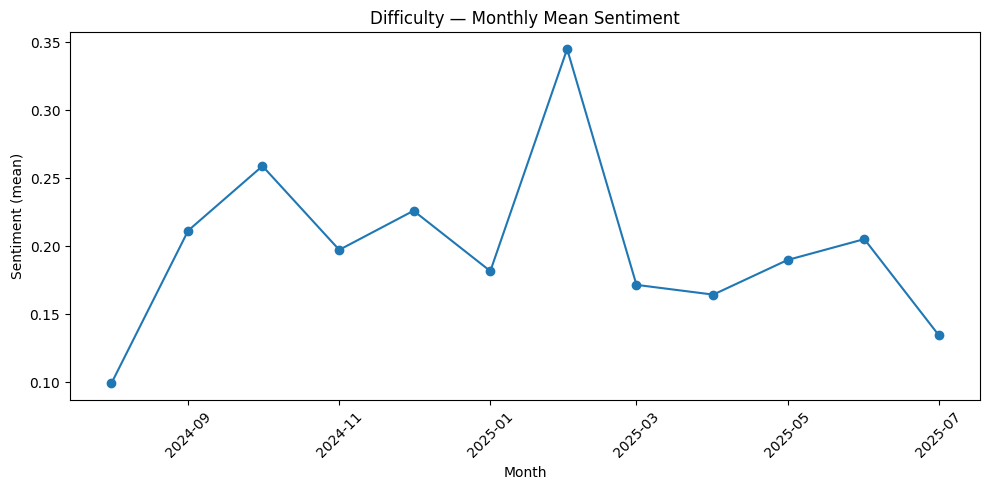

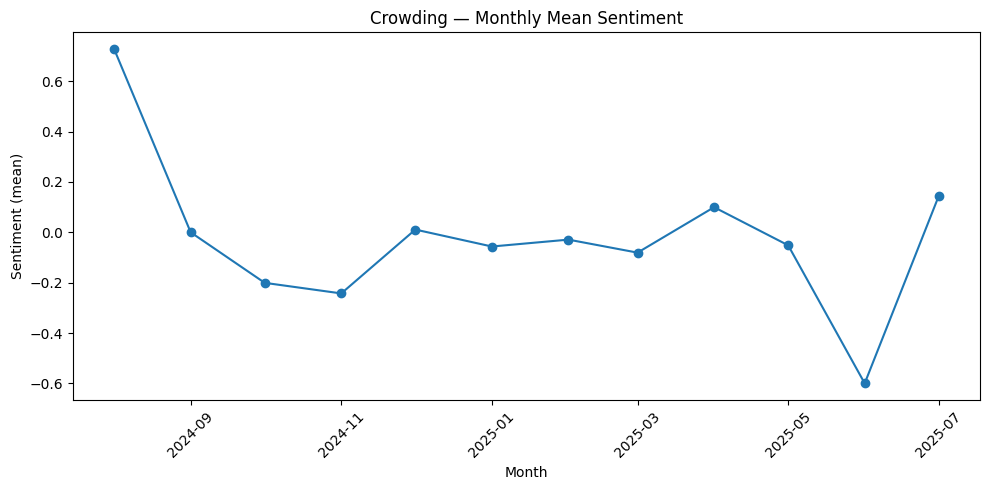

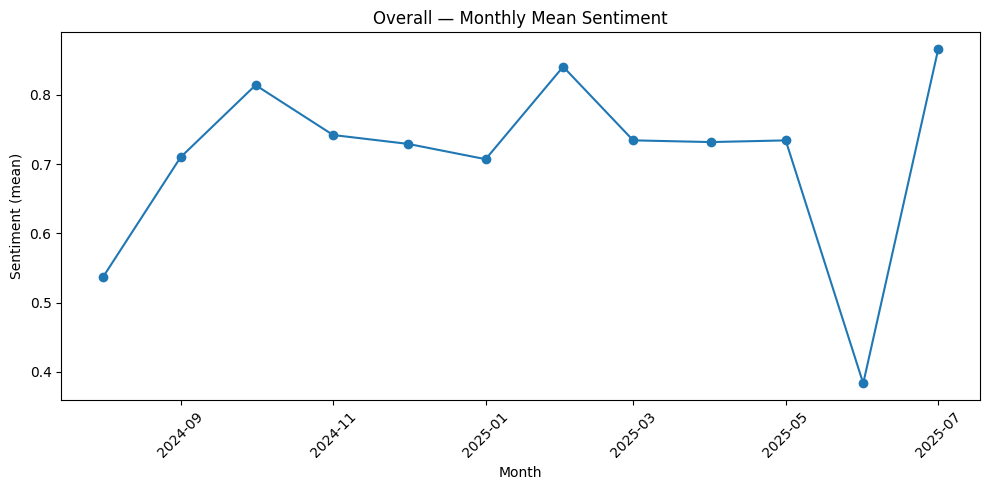

In [22]:
def plot_monthly(series, title, ylabel="Sentiment (mean)", xlabel="Month"):
    plt.figure(figsize=(10, 5))
    plt.plot(monthly['Month'], series, marker='o')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

for cat in categories.keys():
    col = f"{cat}_sent_mean"
    if col in monthly.columns:
        plot_monthly(monthly[col], f"{cat} — Monthly Mean Sentiment")

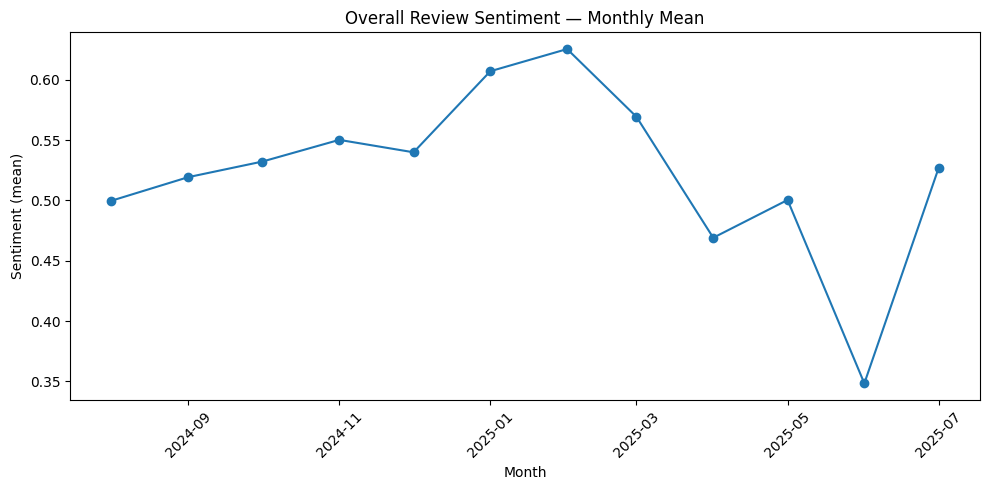

In [23]:
# Overall review sentiment trend
if 'Overall_Review_sent_mean' in monthly.columns:
    plot_monthly(monthly['Overall_Review_sent_mean'], "Overall Review Sentiment — Monthly Mean")

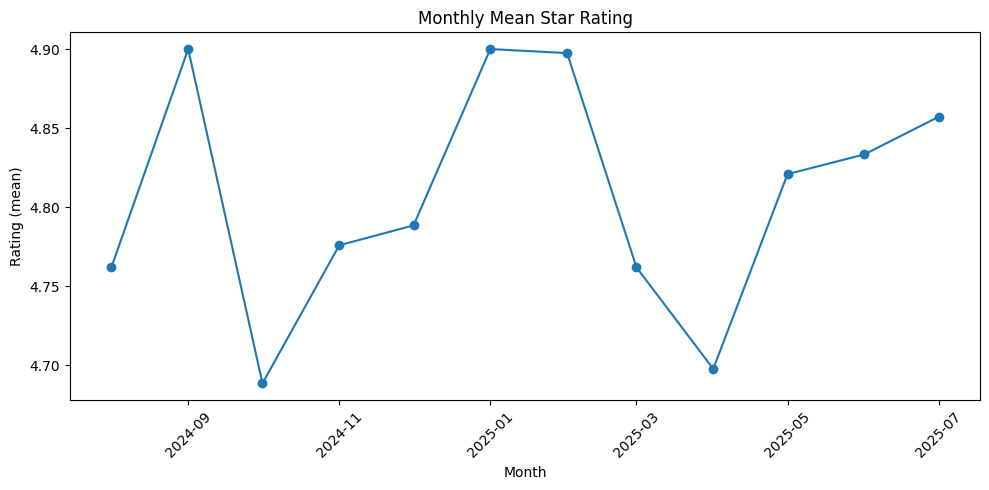

In [24]:
# Monthly mean star rating
if 'Rating_mean' in monthly.columns:
    plot_monthly(monthly['Rating_mean'], "Monthly Mean Star Rating", ylabel="Rating (mean)")

## Save Monthly Summary

In [25]:
import os
OUT_SUMMARY = os.path.join('Prototype', 'monthly_sentiment_summary.csv')
os.makedirs('Prototype', exist_ok=True)
monthly.to_csv(OUT_SUMMARY, index=False)
print(f"[Saved] Monthly sentiment summary -> {OUT_SUMMARY}")

[Saved] Monthly sentiment summary -> Prototype/monthly_sentiment_summary.csv


## Quick Looks

In [26]:
def top_months(col_name, n=5, biggest=True):
    if col_name not in monthly.columns:
        return pd.DataFrame()
    dfv = monthly[['Month', col_name]].dropna().copy()
    return dfv.sort_values(col_name, ascending=not biggest).head(n)

print("\nTop 5 months for positive 'Views' sentiment:")
print(top_months('Views_sent_mean', 5, True))

print("\nTop 5 months for negative 'Crowding' sentiment:")
print(top_months('Crowding_sent_mean', 5, False))


Top 5 months for positive 'Views' sentiment:
        Month  Views_sent_mean
2  2024-10-01         0.632676
7  2025-03-01         0.617925
6  2025-02-01         0.616890
4  2024-12-01         0.572274
11 2025-07-01         0.539087

Top 5 months for negative 'Crowding' sentiment:
        Month  Crowding_sent_mean
10 2025-06-01           -0.600000
3  2024-11-01           -0.242792
2  2024-10-01           -0.200760
7  2025-03-01           -0.080796
5  2025-01-01           -0.056440
